## Load libraries

In [1]:
import os
import logging

import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

from alphai_watson.performance import GANPerformanceAnalysis
from alphai_watson.transformer import NullTransformer
from alphai_rickandmorty_oracle.datasource.kddcup99 import KDDCup99DataSource
from alphai_rickandmorty_oracle.detective import RickAndMortyDetective
from alphai_rickandmorty_oracle.model import RickAndMorty

from alphai_rickandmorty_oracle.architecture.kddcup99 import KDDCup99GanArchitecture

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%matplotlib inline


/home/gmariotti/miniconda3/envs/rickmorty/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.


Uppercase local vars:
	BATCH_SIZE: 50
	CRITIC_ITERS: 5
	DEFAULT_FIT_EPOCHS: 1000
	DEFAULT_LEARN_RATE: 0.0001
	DEFAULT_TRAIN_ITERS: 5000
	DEFAULT_Z_DIM: 200
	DIAGNOSIS_LEARN_RATE: 0.01


## Define KDDCup99 Datasource

In [2]:
file_path = '../../tests/resources'
data_filename = os.path.join(file_path, 'kddcup.data_10_percent_corrected')
header_filename = os.path.join(file_path, 'kddcup.names')

kdd_datasource = KDDCup99DataSource(source_file=data_filename,
                                    header_file=header_filename,
                                    transformer=NullTransformer(8, 8))

data_normal_train = kdd_datasource.get_train_data('NORMAL')
data_normal_test = kdd_datasource.get_train_data('NORMAL_TEST')
data_abnormal_test = kdd_datasource.get_train_data('ABNORMAL_TEST')

## Define Model

In [3]:
model_dir = './kddcup99_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

batch_size = 64
output_dimensions = 121
plot_dimensions = (11, 11)
train_iters = 10000
plot_save_path = model_dir

architecture = KDDCup99GanArchitecture(output_dimensions, plot_dimensions)

model = RickAndMorty(architecture=architecture,
                     batch_size=batch_size,
                     train_iters=train_iters,
                     plot_save_path=plot_save_path)

detective = RickAndMortyDetective(model_configuration={
    'model': model,
    'batch_size': model.batch_size,
    'output_dimensions': model.architecture.output_dimensions,
    'save_path' : '{}/KDDCup99-model'.format(model_dir),
    'plot_save_path': plot_save_path
    
})

### Train

iter 0	train disc cost	1.386181116104126	time	0.1614992618560791
iter 1	train disc cost	1.3855481147766113	time	0.07322120666503906	train gen cost	0.6927355527877808
iter 2	train disc cost	1.3848164081573486	time	0.056397438049316406	train gen cost	0.6929333209991455
iter 3	train disc cost	1.3837560415267944	time	0.041968584060668945	train gen cost	0.692972719669342
iter 4	train disc cost	1.3822797536849976	time	0.04469728469848633	train gen cost	0.6930103898048401
iter 99	train disc cost	0.694916844367981	time	0.04443248196652061	train gen cost	1.590634822845459
iter 199	train disc cost	0.27821996808052063	time	0.037103824615478516	train gen cost	7.5160064697265625
iter 299	train disc cost	0.2772691249847412	time	0.03982063770294189	train gen cost	8.954423904418945
iter 399	train disc cost	0.2883557975292206	time	0.03944494247436523	train gen cost	6.743696689605713
iter 499	train disc cost	0.4332467317581177	time	0.038658416271209715	train gen cost	3.019542932510376
iter 599	train dis

iter 7599	train disc cost	0.918056309223175	time	0.04236006736755371	train gen cost	1.1271257400512695
iter 7699	train disc cost	1.048992395401001	time	0.03560416221618652	train gen cost	1.0495659112930298
iter 7799	train disc cost	1.0419613122940063	time	0.043072171211242676	train gen cost	1.0056849718093872
iter 7899	train disc cost	0.9504570960998535	time	0.034613361358642576	train gen cost	0.9959720373153687
iter 7999	train disc cost	0.9264014363288879	time	0.04350065231323242	train gen cost	1.062441349029541
iter 8099	train disc cost	1.0001375675201416	time	0.034525744915008545	train gen cost	1.0978859663009644
iter 8199	train disc cost	0.8981410264968872	time	0.04334348917007446	train gen cost	1.075154423713684
iter 8299	train disc cost	0.8953348398208618	time	0.035030856132507324	train gen cost	1.089355230331421
iter 8399	train disc cost	0.910946786403656	time	0.0427360725402832	train gen cost	1.1142547130584717
iter 8499	train disc cost	0.9425634741783142	time	0.035762088298797

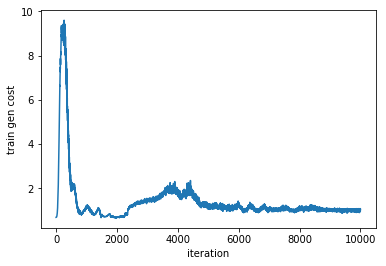

In [4]:
detective.train(data_normal_train);

### Plot cost curves

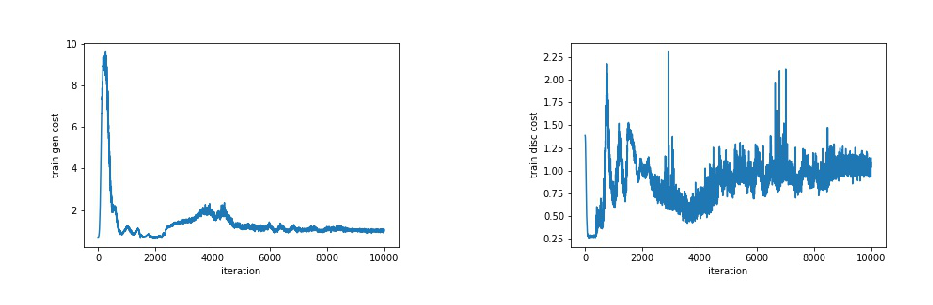

In [5]:
gen_cost_img = mpimg.imread(os.path.join(plot_save_path, 'train_gen_cost.jpg'))
disc_cost_img = mpimg.imread(os.path.join(plot_save_path, 'train_disc_cost.jpg'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.imshow(gen_cost_img);
ax1.axis('off');
ax2.imshow(disc_cost_img);
ax2.axis('off');

## Evaluate results
***

### Visualise generated samples

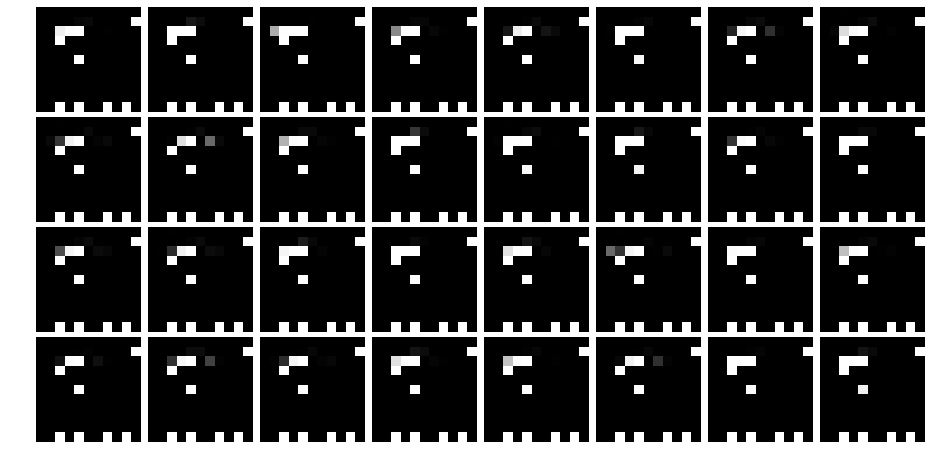

In [6]:
n_row = 4
n_col = 8

plt.figure(figsize=(2*n_col, 2*n_row))

gs = gridspec.GridSpec(n_row, n_col)
gs.update(wspace=0.025, hspace=0.05)

generated_samples = detective.model.generate_fake_samples()

for i in range(n_row * n_col):
    ax = plt.subplot(gs[i])
    ax.axis('off')
    ax.imshow(generated_samples[i], cmap='gray')

### Collate ground truth and detection results

In [7]:
n1 = np.ones(len(data_normal_test.data))
n2 = np.zeros(len(data_abnormal_test.data))

ground_truth = np.hstack((n1, n2))

test_results_normal = detective.detect(data_normal_test).data 
test_results_abnormal = detective.detect(data_abnormal_test).data 

predictions = np.hstack((test_results_normal, test_results_abnormal))

### Calculate ROC Score

In [8]:
roc_score = GANPerformanceAnalysis({}).analyse(
  detection_result=predictions,
  expected_truth=ground_truth
)

print('ROC Score: {}'.format(roc_score))

ROC Score: 0.17939802430986942


### Calculate training accuracy

In [9]:
def model_accuracy(data, status, threshold=None):
    results = detective.detect(data).data 
    if threshold is None:
        threshold = np.median(results)
    ground_truth = [status] * len(results)
    prediction = [1 if x >= threshold else 0 for x in results]
    print('Accuracy: {0:.2f}%'.format(100*accuracy_score(ground_truth, prediction)))
    return threshold

In [10]:
threshold = model_accuracy(data_normal_train, 1)

Accuracy: 50.00%


### Generate classification report

In [12]:
class_predictions = [1 if x >= threshold else 0 for x in predictions]

target_names = ['ABNORMAL', 'NORMAL']
print(classification_report(ground_truth, class_predictions, target_names=target_names))

              precision    recall  f1-score   support

    ABNORMAL       0.00      0.00      0.00    396743
      NORMAL       0.04      0.50      0.07     29183

   micro avg       0.03      0.03      0.03    425926
   macro avg       0.02      0.25      0.03    425926
weighted avg       0.00      0.03      0.00    425926



## Root Cause Analysis

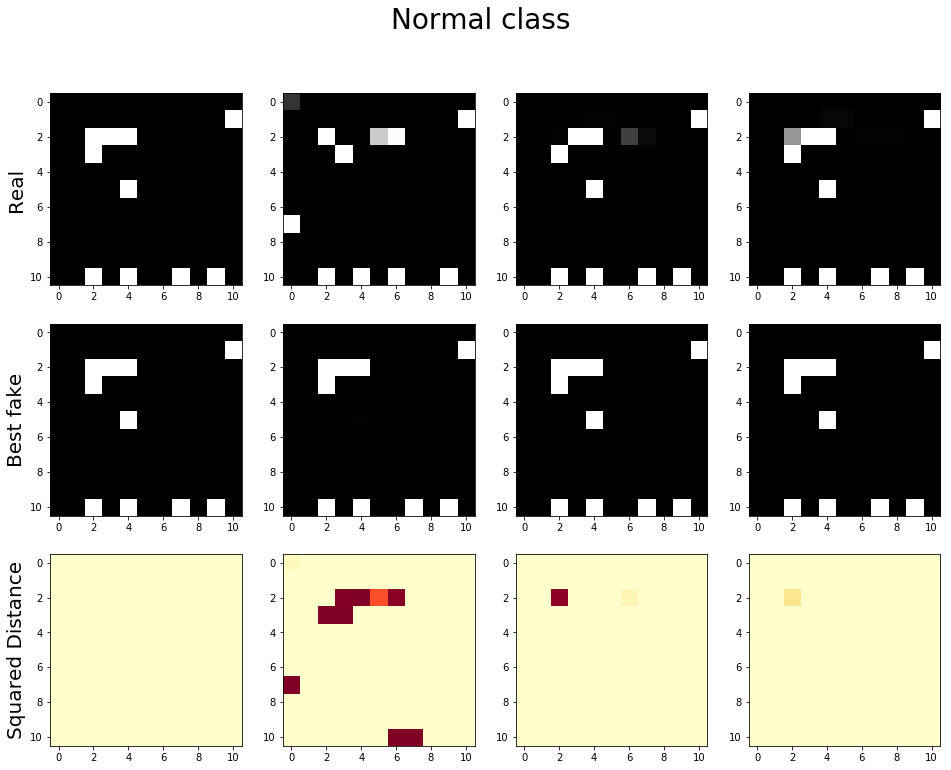

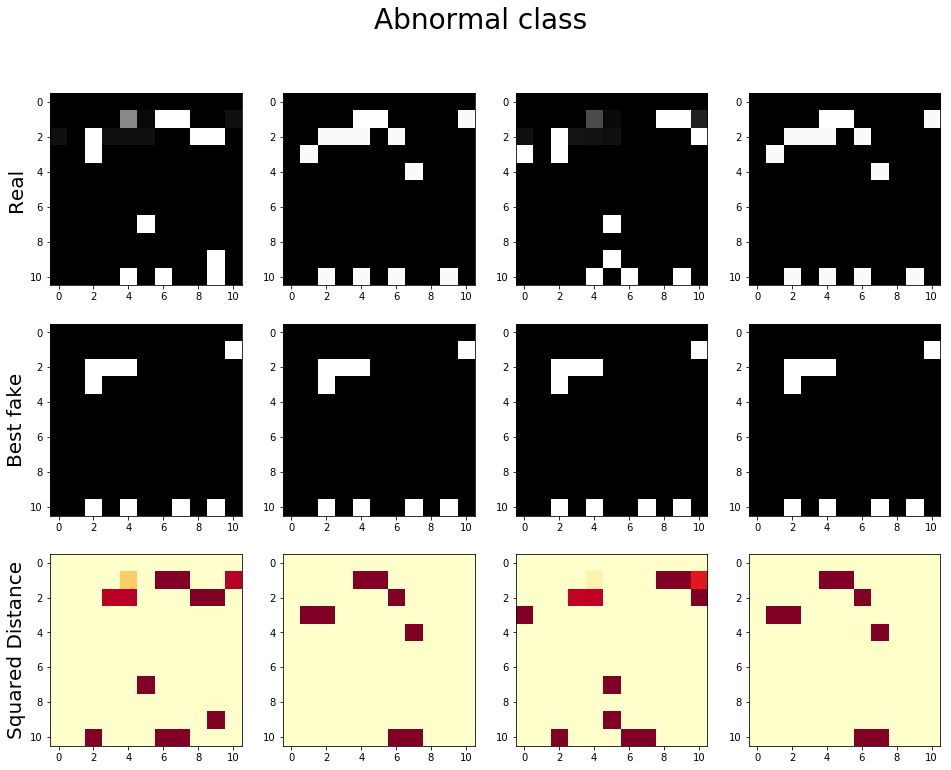

In [13]:
n_img = 4

normal_test_samples = \
    data_normal_test.data[np.random.choice(data_normal_test.data.shape[0], n_img, replace=False), :]
abnormal_test_samples = \
    data_abnormal_test.data[np.random.choice(data_abnormal_test.data.shape[0], n_img, replace=False), :]

normal_best_fakes = [detective.diagnose(nor_img) for nor_img in normal_test_samples]
abnormal_best_fakes = [detective.diagnose(abn_img) for abn_img in abnormal_test_samples]

# Plot normal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Normal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(np.reshape(normal_test_samples[i], (11, 11)), cmap='gray'); 
    ax[1, i].imshow(np.reshape(normal_best_fakes[i], (11, 11)), cmap='gray')
    ax[2, i].imshow(np.reshape(np.square(normal_test_samples[i] - normal_best_fakes[i]), (11, 11)), 
                    cmap='YlOrRd', vmin=0, vmax=1)

# Plot abnormal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Abnormal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(np.reshape(abnormal_test_samples[i], (11, 11)), cmap='gray'); 
    ax[1, i].imshow(np.reshape(abnormal_best_fakes[i], (11, 11)), cmap='gray')
    ax[2, i].imshow(np.reshape(np.square(abnormal_test_samples[i] - abnormal_best_fakes[i]), (11, 11)), 
                    cmap='YlOrRd', vmin=0, vmax=1)